## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve, get_lstm_data_gen
from dataset_path import output_path

path = output_path

output_path = os.path.join(path, "Figure3")
if not os.path.exists(output_path):
    os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,394512,10509415,NaN,39157213,2178-11-07 21:01:00,2178-11-07 21:26:00,45,M,2173,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,50,False,False,False,0 days 00:25:00,NaN,NaN,False,False,False,0,0,0,2178-11-09 10:37:00,1 days 13:11:00,True,0,0,0,0,0,0,0.42,NaN,1.55,36.722222,74.0,20.0,100.0,162.0,129.0,9.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,72.0,16.0,100.0,180.0,123.0,0.0,3.0,9.0,140.000000,2,0,5,0,0,1
1,163920,19402485,27265022.0,35695207,2149-04-10 22:36:00,2149-04-11 00:47:05,55,M,2149,NaN,2149-04-11 00:46:00,2149-04-12 15:00:00,NaN,BLACK/AFRICAN AMERICAN,2149-04-10 22:36:00,2149-04-11 03:20:00,Other,2149,55,False,False,False,0 days 02:11:05,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,2.18,NaN,NaN,36.777778,90.0,20.0,97.0,131.0,77.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,68.0,18.0,100.0,128.0,68.0,0.0,2.0,6.0,95.000000,1,4,3,0,0,1
2,235492,12126972,21011915.0,33586273,2110-03-31 10:59:00,2110-03-31 15:33:00,65,F,2110,NaN,2110-03-31 14:50:00,2110-04-02 13:40:00,NaN,WHITE,2110-03-31 10:59:00,2110-03-31 15:33:00,Other,2110,65,False,False,False,0 days 04:34:00,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,4.57,NaN,NaN,36.833333,90.0,18.0,94.0,122.0,71.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.333333,84.0,22.0,93.0,138.0,80.0,4.0,4.0,3.0,88.000000,2,4,5,1,0,1
3,43991,17759885,NaN,31346320,2155-01-03 09:43:00,2155-01-03 09:54:00,63,F,2154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2155,64,False,False,False,0 days 00:11:00,NaN,NaN,False,False,False,0,1,1,2155-02-10 12:49:00,38 days 02:55:00,False,0,0,0,0,0,0,0.18,NaN,38.12,36.611111,98.0,14.0,99.0,136.0,71.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.222222,85.0,14.0,99.0,138.0,78.0,0.0,0.0,4.0,92.666667,2,4,3,1,1,0
4,291495,12197131,26028634.0,34998956,2123-07-30 11:41:00,2123-07-30 23:24:00,60,M,2123,NaN,2123-07-30 17:24:00,2123-08-08 13:02:00,NaN,OTHER,2123-07-30 11:41:00,2123-07-30 23:24:00,Medicaid,2123,60,False,False,False,0 days 11:43:00,NaN,NaN,False,True,False,0,0,0,2125-08-30 20:50:00,761 days 21:26:00,False,0,0,0,0,0,0,11.72,NaN,761.89,36.833333,82.0,16.0,100.0,125.0,85.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,75.0,17.0,100.0,144.0,80.0,0.0,7.0,8.0,98.333333,2,4,3,0,0,1


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)].reset_index()

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [10]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.04792089249492901 : 1


### 3.  Modeling script

In [11]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/virtualenvs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.2136549949645996 seconds
AUC: 0.6829986309055054
AUPRC: 0.15453248878421846
Sensitivity: 0.619533527696793
Specificity: 0.6416767976946283
Score thresold: 0.0402902618468163
2.5 97.5


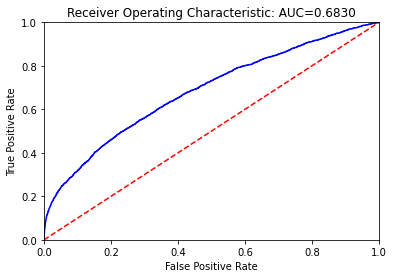

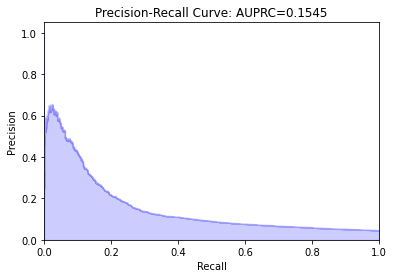

In [12]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 28.49911403656006 seconds
AUC: 0.6620308434830677
AUPRC: 0.14403618511188246
Sensitivity: 0.6020408163265306
Specificity: 0.6215498221441758
Score thresold: 0.05
2.5 97.5


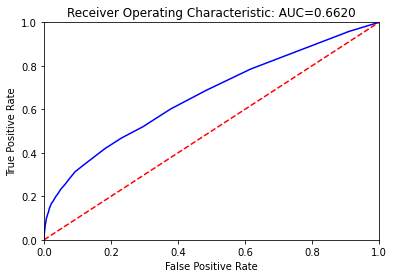

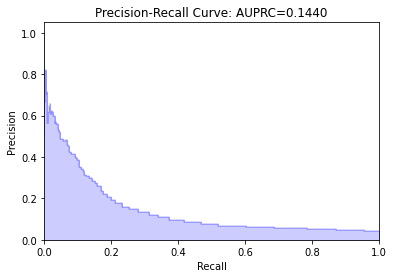

[0.08327607 0.01383593 0.01987954 0.02478789 0.03485467 0.00926022
 0.01221601 0.02000422 0.00104142 0.00193283 0.00413015 0.04424587
 0.02170126 0.00544799 0.00863492 0.00588284 0.00030204 0.00562893
 0.00261901 0.0040935  0.00301252 0.00210999 0.00303975 0.00273733
 0.00285562 0.00254494 0.00273725 0.00126888 0.00577462 0.00187595
 0.00163923 0.0039559  0.0051206  0.00284942 0.00154277 0.0026956
 0.00331604 0.00140482 0.00177181 0.00171031 0.00507935 0.00234898
 0.00230356 0.00280434 0.00655374 0.00464726 0.00368554 0.0011432
 0.00360605 0.00457205 0.00294902 0.00549135 0.00144005 0.0036604
 0.00591136 0.00474518 0.00348918 0.00618529 0.0676574  0.07597874
 0.0379419  0.04054789 0.0790387  0.07637901 0.0831943  0.03921806
 0.05168941]


In [13]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 30.2500638961792 seconds
AUC: 0.6986145039826394
AUPRC: 0.16213303007214114
Sensitivity: 0.652575315840622
Specificity: 0.6307352874960601
Score thresold: 0.037551393403421084
2.5 97.5


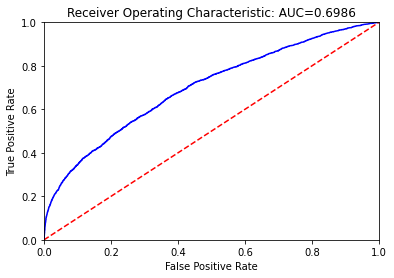

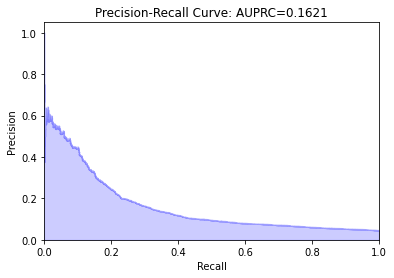

In [14]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [16]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp')

2022-01-13 13:15:09.014980: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-13 13:15:09.820074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21029 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-01-13 13:15:09.821067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21881 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/20
 40/930 [>.............................] - ETA: 3s - loss: 1.2897 - accuracy: 0.9100 - auc: 0.5062 - auprc: 0.0468 - true_positives: 16.0000 - true_negatives: 7264.0000 - precision: 0.0415 - recall: 0.0437  

2022-01-13 13:15:11.524450: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


930/930 [==============================] - 6s 5ms/step - loss: 0.2330 - accuracy: 0.9513 - auc: 0.6125 - auprc: 0.0990 - true_positives: 334.0000 - true_negatives: 176594.0000 - precision: 0.2738 - recall: 0.0393
Epoch 2/20
930/930 [==============================] - 5s 5ms/step - loss: 0.1793 - accuracy: 0.9542 - auc: 0.6416 - auprc: 0.1333 - true_positives: 336.0000 - true_negatives: 177130.0000 - precision: 0.4898 - recall: 0.0395
Epoch 3/20
930/930 [==============================] - 5s 5ms/step - loss: 0.1774 - accuracy: 0.9541 - auc: 0.6483 - auprc: 0.1373 - true_positives: 303.0000 - true_negatives: 177145.0000 - precision: 0.4749 - recall: 0.0356
Epoch 4/20
930/930 [==============================] - 5s 5ms/step - loss: 0.1759 - accuracy: 0.9544 - auc: 0.6564 - auprc: 0.1406 - true_positives: 304.0000 - true_negatives: 177202.0000 - precision: 0.5223 - recall: 0.0357
Epoch 5/20
930/930 [==============================] - 5s 5ms/step - loss: 0.1742 - accuracy: 0.9544 - auc: 0.6630 -

2022-01-13 13:16:43.439704: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 72h_ed_revisit_mlp/assets


MLP:
AUC: 0.6961475532752482
AUPRC: 0.15960773661432348
Sensitivity: 0.6253644314868805
Specificity: 0.651987932820028
Score thresold: 0.03963747
2.5 97.5


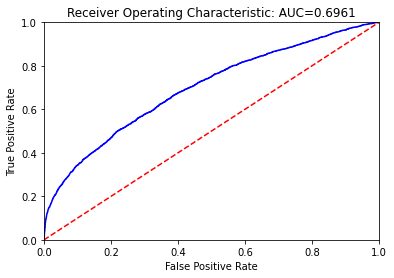

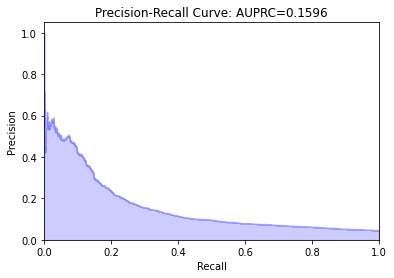

In [17]:
print("MLP:")
#mlp = load_model('72h_ed_revisit_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [18]:
# Loading data for LSTM
resample_freq = '1H' #'30T'
df_vitalsign = pd.read_csv(os.path.join(path, 'ed_vitalsign_' + resample_freq + '_resampled.csv'))

In [19]:
train_data_gen, test_data_gen = get_lstm_data_gen(df_train, df_test, df_vitalsign, variable, outcome)

In [20]:
class LSTM_MLP(tf.keras.Model):
    def __init__(self):
        super(LSTM_MLP, self).__init__()
        self.dense_1 = Dense(96, activation='relu')
        self.lstm = LSTM(32)
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x1, x2 = x
        x = self.dense_1(x1)
        lstm_output = self.lstm(x2)
        x = concatenate([x, lstm_output])
        x = self.dense_2(x)
        return self.classifier(x)

In [21]:
# skip this cell if not retraining
lstm = LSTM_MLP()
lstm.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

start = time.time()
lstm.fit(train_data_gen, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
lstm.save('72h_ed_revisit_lstm')

2022-01-13 13:16:50.846582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


Epoch 1/20
930/930 [==============================] - 522s 559ms/step - loss: 0.1900 - accuracy: 0.9518 - auc: 0.6217 - auprc: 0.1051 - true_positives: 304.0000 - true_negatives: 176723.0000 - precision: 0.2865 - recall: 0.0357
Epoch 2/20
930/930 [==============================] - 522s 561ms/step - loss: 0.1738 - accuracy: 0.9544 - auc: 0.6647 - auprc: 0.1495 - true_positives: 297.0000 - true_negatives: 177200.0000 - precision: 0.5147 - recall: 0.0349
Epoch 3/20
930/930 [==============================] - 521s 560ms/step - loss: 0.1729 - accuracy: 0.9544 - auc: 0.6713 - auprc: 0.1531 - true_positives: 270.0000 - true_negatives: 177243.0000 - precision: 0.5325 - recall: 0.0317
Epoch 4/20
930/930 [==============================] - 522s 561ms/step - loss: 0.1726 - accuracy: 0.9547 - auc: 0.6700 - auprc: 0.1567 - true_positives: 280.0000 - true_negatives: 177275.0000 - precision: 0.5773 - recall: 0.0329
Epoch 5/20
930/930 [==============================] - 523s 562ms/step - loss: 0.1718 - a

INFO:tensorflow:Assets written to: 72h_ed_revisit_lstm/assets


INFO:tensorflow:Assets written to: 72h_ed_revisit_lstm/assets


LSTM:
AUC: 0.6966022899514425
AUPRC: 0.1582120312437999
Sensitivity: 0.6365403304178814
Specificity: 0.6573010941510198
Score thresold: 0.03806601
2.5 97.5


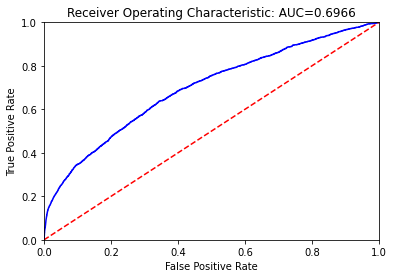

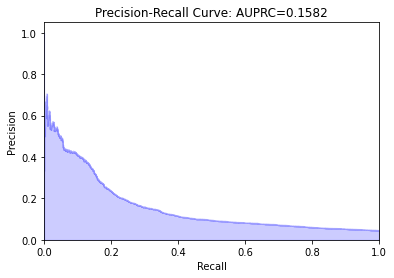

In [22]:
print("LSTM:")
lstm = load_model('72h_ed_revisit_lstm')
probs = lstm.predict(test_data_gen)
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LSTM"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [23]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [24]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


In [25]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_ED_revisit.csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

AutoScore
AUC: 0.6725817495520624
AUPRC: 0.11388656627666868
Sensitivity: 0.6209912536443148
Specificity: 0.6277184925030392
Score thresold: 27
2.5 97.5


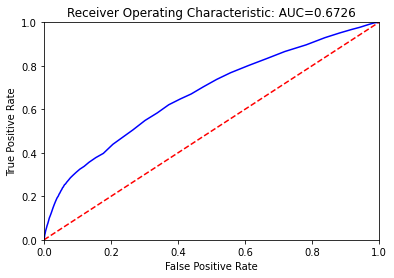

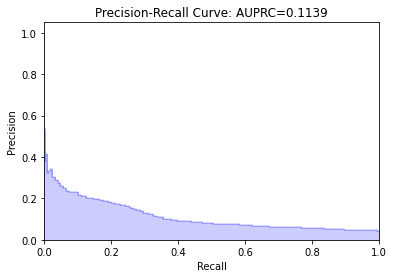

In [26]:
get_score_performance("AutoScore", random_seed=random_seed) 

In [27]:
import tensorflow as tf
tf.random.set_seed(random_seed)
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [28]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 256)          262400      ['tf.math.reduce_su

INFO:tensorflow:Assets written to: embedding_revisit_v10/assets


INFO:tensorflow:Assets written to: embedding_revisit_v10/assets


AUC: 0.6781818308715842
AUPRC: 0.13943642662597272
Sensitivity: 0.6219630709426628
Specificity: 0.6296996713044261
Score thresold: 0.0019228882
2.5 97.5


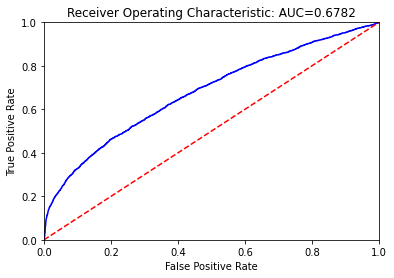

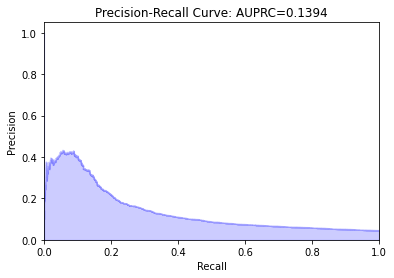

In [29]:
# To train from scratch, set load_model to None
load_model = "embedding_revisit_"+version 
save_model = "embedding_revisit_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [30]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'formatted_result_72h_ed_revivist_disposition.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.040,0.683 (0.677-0.697),0.155 (0.141-0.169),0.62 (0.604-0.643),0.642 (0.622-0.665),3.214
1,RF,0.050,0.662 (0.647-0.674),0.144 (0.132-0.157),0.602 (0.573-0.619),0.622 (0.617-0.625),28.499
2,GB,0.038,0.699 (0.689-0.712),0.162 (0.149-0.177),0.653 (0.618-0.673),0.631 (0.618-0.661),30.250
3,MLP,0.040,0.696 (0.687-0.709),0.16 (0.146-0.174),0.625 (0.602-0.675),0.652 (0.61-0.681),93.237
4,LSTM,0.038,0.697 (0.683-0.712),0.158 (0.144-0.171),0.637 (0.612-0.659),0.657 (0.651-0.678),10454.207
5,AutoScore,27.000,0.673 (0.665-0.684),0.114 (0.107-0.124),0.621 (0.596-0.637),0.628 (0.622-0.665),0.000
6,Med2Vec,0.002,0.678 (0.67-0.694),0.139 (0.129-0.151),0.622 (0.57-0.64),0.63 (0.62-0.7),1063.299


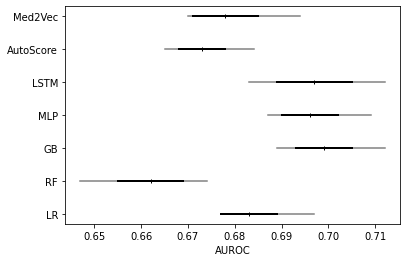

In [31]:
from helpers import plot_confidence_interval
#plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC" )
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_72h.eps', my_path = output_path) 

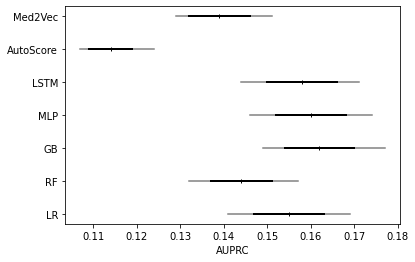

In [32]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_72h.eps', my_path = output_path)

In [33]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.083276
64,ed_los,0.083194
62,ed_sbp_last,0.079039
63,ed_dbp_last,0.076379
59,ed_heartrate_last,0.075979
58,ed_temperature_last,0.067657
66,n_medrecon,0.051689
11,triage_pain,0.044246
61,ed_o2sat_last,0.040548
65,n_med,0.039218
